In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, KFold
from imblearn.over_sampling import SMOTE

gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpus, True)
    print("GPU 환경에서 실행됩니다.")
else:
    print("GPU가 감지되지않습니다. CPU환경에서 실행됩니다.")

GPU가 감지되지않습니다. CPU환경에서 실행됩니다.


In [27]:
import os
file_path = os.getcwd()
train_path = os.path.join(file_path, "데이터셋", "train.csv")
test_path = os.path.join(file_path, "데이터셋", "test.csv")
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [28]:
def preprocess(df):
    df = df.copy()
    def year(x):
        return "".join(v.replace("이상", "").replace("년", "") for v in x.split(" "))

    def year1(x):
        return "".join(v.replace('1미만', "0") for v in x.split(" "))
    
    df["신용 거래 연수"] = df["신용 거래 연수"].astype(int)
    
    
    cols = (["주거 형태","대출 목적", "대출 상환 기간"])
    for c in cols:
        lb = LabelEncoder()
        lb.fit(df[c].values)
        df[c] = lb.transform(list(df[c].values))
        df[c] = df[c].astype(int)

 
    df["현재 직장 근속 연수"] = df["현재 직장 근속 연수"].apply(year)
    df["현재 직장 근속 연수"] = df["현재 직장 근속 연수"].apply(year1).astype(int)
    df["현재 대출 잔액"] = df["현재 대출 잔액"].where((df["현재 대출 잔액"] > 0), np.nan)
    df["현재 대출 잔액"] = df["현재 대출 잔액"].fillna(df["현재 대출 잔액"].median())
    df["최대 신용한도"] = df["최대 신용한도"].where((df["최대 신용한도"] > 0), np.nan)
    df["최대 신용한도"] = df["최대 신용한도"].fillna(df["최대 신용한도"].median())
    df["대출액+신용액"] = df["현재 대출 잔액"] + df["현재 미상환 신용액"]
    df["상환액 분위"] = pd.qcut(df["대출액+신용액"], 5, labels = [1,2,3,4,5], duplicates = "drop").astype(int)

    df["신용거래분위"] = pd.qcut(df["신용 거래 연수"], 5, labels = [1,2,3,4,5], duplicates = "drop").astype(int)
    df["신용점수분위"] = pd.qcut(df["신용 점수"], 5, labels = [1,2,3,4,5], duplicates= "drop").astype(int)

    df["연간소득분위"] = pd.qcut(df["연간 소득"], 5, labels = [1,2,3,4,5], duplicates = "drop").astype(int)
    df["개설된_신용계좌_분위수"] = pd.qcut(df["개설된 신용계좌 수"], 5, labels = [1,2,3,4,5], duplicates = "drop").astype(int)
    df["대출잔액 분위수"] = pd.qcut(df["현재 대출 잔액"], 5, labels = [1,2,3,4,5], duplicates= "drop").astype(int)
    df["직장근속연수 분위수"] = pd.qcut(df["현재 직장 근속 연수"], 7, labels = [1,2,3,4,5], duplicates= "drop").astype(int)
    

    df["신용한도vs대출잔액"] = (df["현재 대출 잔액"] + df["현재 미상환 신용액"] )  / ((df["최대 신용한도"] * df["개설된 신용계좌 수"]))* 100

    df["DTI"] = ((df["현재 대출 잔액"] + df["현재 미상환 신용액"]) / df["연간 소득"]) * 100
    df["DTR"] = ((df["월 상환 부채액"] + 1) / (df["연간 소득"] / 12)) * 100

    df["DTI분위"] = pd.qcut(df["DTI"], 5, labels = [1,2,3,4,5], duplicates= "drop").astype(int)
    df["DTR분위"] = pd.qcut(df["DTR"], 5, labels = [1,2,3,4,5], duplicates= "drop").astype(int)
    df["DBI"] = (df["DTI"] + df["DTR"]) / 2
    df["DRS"] = (df["DTI"] * df["DTR"])

    df["신용위험"] = ((df["개설된_신용계좌_분위수"] >= 3) & (df["신용점수분위"] <= 3) & (df["신용거래분위"] <= 3)).astype(int)
    df["소득위험"] = ((df["직장근속연수 분위수"] < 3) & (df["연간소득분위"] < 3)).astype(int)
    df["대출위험"] = ((df["상환액 분위"] > 3) & (df["DTR분위"] < 3)).astype(int)
    df["파산위험"] = ((df["신용 문제 발생 횟수"] > 0) & ((df["개인 파산 횟수"] > 0) | (df["체납 세금 압류 횟수"] > 0))).astype(int)
    df["부채통합위험"] = ((df["대출 목적"] == 4) & (df["DTI분위"] > 3)).astype(int)
    df["부채통합위험2"] = ((df["대출 목적"] == 4) & (df["신용위험"] == 1)).astype(int)
    

    df["위험분자"] = df["신용위험"] + df["소득위험"] + df["대출위험"] + df["파산위험"] + df["부채통합위험"] + df["부채통합위험2"]


    df["근속연수vs거래연수"] = (df["현재 직장 근속 연수"] / df["신용 거래 연수"]) * 100


    #df["위험도 점수"] = df["신용점수분위"] - df["상환액 분위"]
    #df["위험도 점수2"] = df["신용거래분위"] - df["개설된_신용계좌_분위수"]
    #df["위험도 점수3"] = df["직장근속연수 분위수"] - df["대출잔액 분위수"]

    #df["문제 발생 점수"] = df["신용 문제 발생 횟수"] + df["개인 파산 횟수"] + df["체납 세금 압류 횟수"]


    #df["VIP"] = ((df["개설된_신용계좌_분위수"] > 3) & (df["신용점수분위"] > 3)).astype(int)


    df["개설계좌vs연체이후개월수"] = df["개설된 신용계좌 수"] / (df["마지막 연체 이후 경과 개월 수"] + 1) * 100

    #df["고위험 대출목적"] = (df["대출 목적"] == 4).astype(int)

    목적별_위험 = df.groupby("대출 목적")["대출 상환 기간"].agg("mean") * 100
    #df["목적별 위험분자 지수"] = df["대출 목적"].map(목적별_위험)
    #df["목적별 위험분자 지수"] = df["목적별 위험분자 지수"].astype(float)
    


    신용거래 = df.groupby("개설된 신용계좌 수")["신용 거래 연수"].agg("mean")
    #df["신용거래연수_개설신용계좌"] = df["개설된 신용계좌 수"].map(신용거래)
    신용대출 = df.groupby("개설된 신용계좌 수")["현재 대출 잔액"].agg("mean")
    #df["신용계좌vs대출잔액"] = df["개설된 신용계좌 수"].map(신용대출)
    #df["신용계좌vs대출잔액"] = df["신용계좌vs대출잔액"] / 10000
    
    bankcount_purpose = df.groupby("대출 목적")["개설된 신용계좌 수"].agg("median")
    purpose_bankcount = df.groupby("개설된 신용계좌 수")["연간 소득"].agg("median")
    #df["계좌수별_소득"] = df["개설된 신용계좌 수"].map(purpose_bankcount)
    #df["계좌수별_소득"] = df["계좌수별_소득"].astype(int)  

    df = df.drop(["대출액+신용액", "DTR분위", "상환액 분위", "DTI분위"], axis = 1)
    
    return df

train = preprocess(train_df)
test = preprocess(test_df)
train.head()

,UID,주거 형태,연간 소득,현재 직장 근속 연수,체납 세금 압류 횟수,개설된 신용계좌 수,신용 거래 연수,최대 신용한도,신용 문제 발생 횟수,마지막 연체 이후 경과 개월 수,...,DRS,신용위험,소득위험,대출위험,파산위험,부채통합위험,부채통합위험2,위험분자,근속연수vs거래연수,개설계좌vs연체이후개월수
0,TRAIN_00000,1,1941337.5,10,0.0,9,13,400597.5,0,24,...,172.848896,0,0,0,0,0,0,0,76.923077,36.000000
1,TRAIN_00001,0,1979505.0,10,0.0,5,15,360679.5,0,11,...,815.630522,0,0,0,0,1,0,1,66.666667,41.666667
2,TRAIN_00002,0,1356381.0,4,0.0,12,18,491770.5,1,74,...,563.229756,0,1,0,1,1,0,3,22.222222,16.000000
3,TRAIN_00003,0,1049017.5,6,0.0,15,14,411546.0,1,22,...,2300.998057,0,0,0,1,1,0,2,42.857143,65.217391
4,TRAIN_00004,0,4320217.5,2,0.0,11,26,895288.5,0,32,...,46.824188,0,0,1,0,0,0,1,7.692308,33.333333


C:\Users\yunju\AppData\Local\Temp\ipykernel_83768\235274021.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train["신용 점수"], color = "b", bins = 100, hist_kws = {"alpha": 0.3})


<Axes: xlabel='신용 점수', ylabel='Density'>

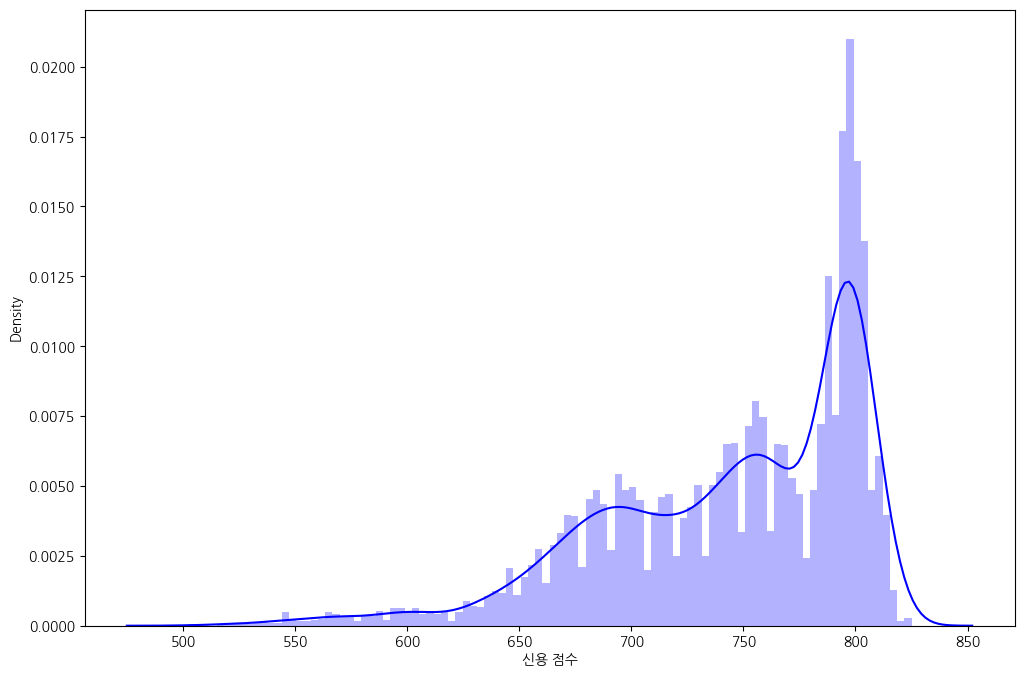

In [29]:
plt.rc("font", family = "NanumGothic")
plt.figure(figsize = (12,8))
sns.distplot(train["신용 점수"], color = "b", bins = 100, hist_kws = {"alpha": 0.3})

In [30]:
target = train["채무 불이행 여부"]
uid = test["UID"]

train = train.drop(["채무 불이행 여부", "UID"], axis = 1)
test = test.drop("UID", axis = 1)

In [31]:
from scipy.stats import boxcox
from scipy.special import boxcox1p

cols = ["최대 신용한도", "연간 소득", "월 상환 부채액", "현재 대출 잔액", "현재 미상환 신용액", "근속연수vs거래연수", "신용한도vs대출잔액", "신용 점수", "DTI", "DTR", "개설계좌vs연체이후개월수", "DBI", "DRS", "개설된 신용계좌 수", "신용 거래 연수"]
for c in cols:
    train[c] = train[c].where((train[c] > 0), np.nan)
    test[c] = test[c].where((test[c] > 0), np.nan)
    train[c] = train[c].fillna(train[c].median())
    test[c] = test[c].fillna(test[c].median())
    
    train[c], l = boxcox(train[c])
    test[c]= boxcox(test[c], lmbda = l)
print(train[cols].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   최대 신용한도        10000 non-null  float64
 1   연간 소득          10000 non-null  float64
 2   월 상환 부채액       10000 non-null  float64
 3   현재 대출 잔액       10000 non-null  float64
 4   현재 미상환 신용액     10000 non-null  float64
 5   근속연수vs거래연수     10000 non-null  float64
 6   신용한도vs대출잔액     10000 non-null  float64
 7   신용 점수          10000 non-null  float64
 8   DTI            10000 non-null  float64
 9   DTR            10000 non-null  float64
 10  개설계좌vs연체이후개월수  10000 non-null  float64
 11  DBI            10000 non-null  float64
 12  DRS            10000 non-null  float64
 13  개설된 신용계좌 수     10000 non-null  float64
 14  신용 거래 연수       10000 non-null  float64
dtypes: float64(15)
memory usage: 1.1 MB
None


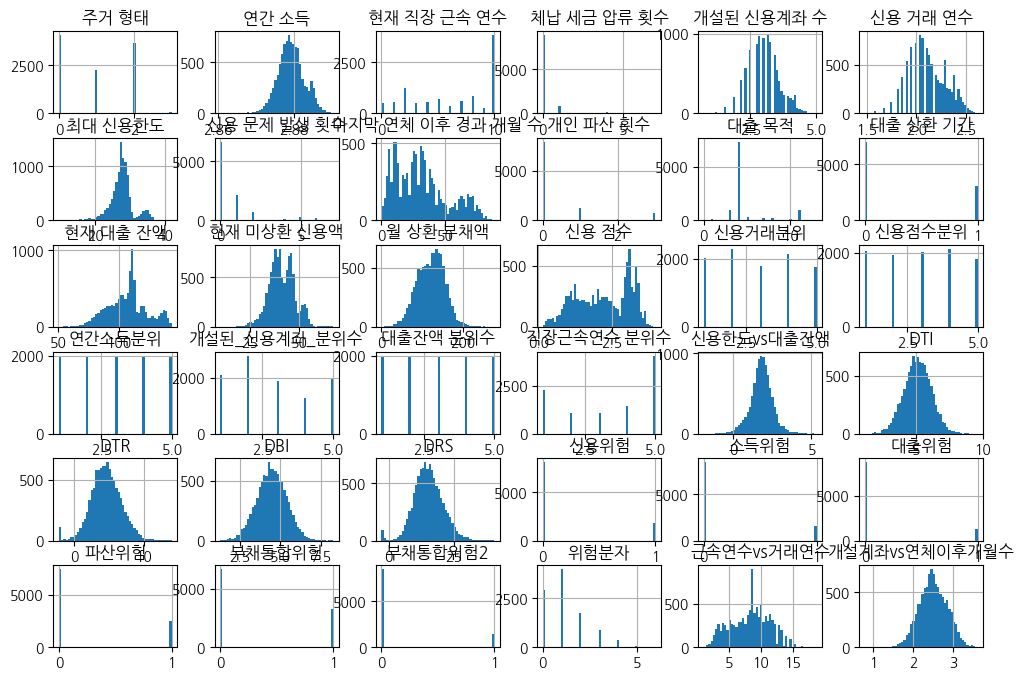

In [32]:
train.hist(figsize = (12,8),bins = 50);

In [33]:
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()
X_scaled = minmax.fit_transform(train)
test_scaled = minmax.transform(test)
"""
standard = StandardScaler()
X_scaled = standard.fit_transform(train)
test_scaled = standard.transform(test)
"""

'\nstandard = StandardScaler()\nX_scaled = standard.fit_transform(train)\ntest_scaled = standard.transform(test)\n'

In [34]:
smote = SMOTE(random_state= 42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, target)

Fold 1 시작!
Epoch 1/100
330/330 [==============================] - 2s 4ms/step - loss: 0.6975 - accuracy: 0.5059 - val_loss: 0.6889 - val_accuracy: 0.5577
Epoch 2/100
330/330 [==============================] - 1s 3ms/step - loss: 0.6913 - accuracy: 0.5235 - val_loss: 0.6841 - val_accuracy: 0.5964
Epoch 3/100
330/330 [==============================] - 1s 3ms/step - loss: 0.6903 - accuracy: 0.5344 - val_loss: 0.6801 - val_accuracy: 0.6077
Epoch 4/100
330/330 [==============================] - 1s 3ms/step - loss: 0.6859 - accuracy: 0.5466 - val_loss: 0.6761 - val_accuracy: 0.6149
Epoch 5/100
330/330 [==============================] - 1s 3ms/step - loss: 0.6821 - accuracy: 0.5649 - val_loss: 0.6720 - val_accuracy: 0.6241
Epoch 6/100
330/330 [==============================] - 1s 2ms/step - loss: 0.6796 - accuracy: 0.5657 - val_loss: 0.6681 - val_accuracy: 0.6347
Epoch 7/100
330/330 [==============================] - 1s 3ms/step - loss: 0.6768 - accuracy: 0.5797 - val_loss: 0.6644 - val_accur

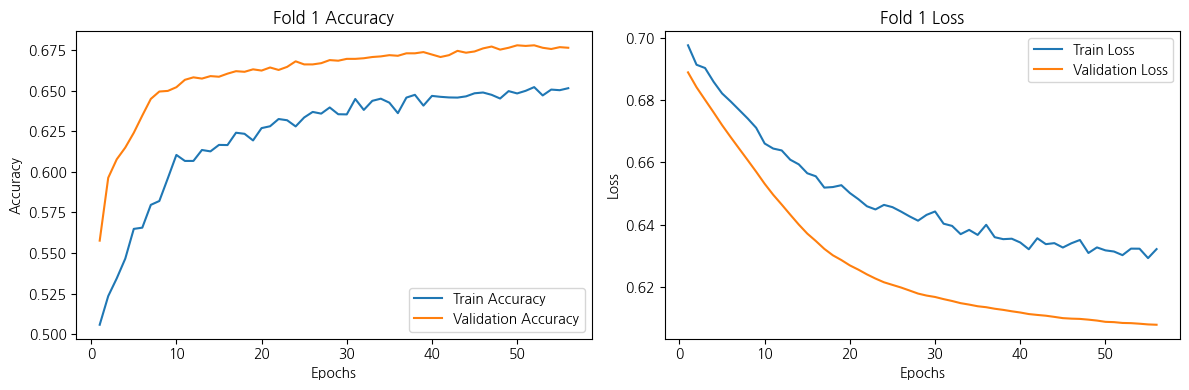

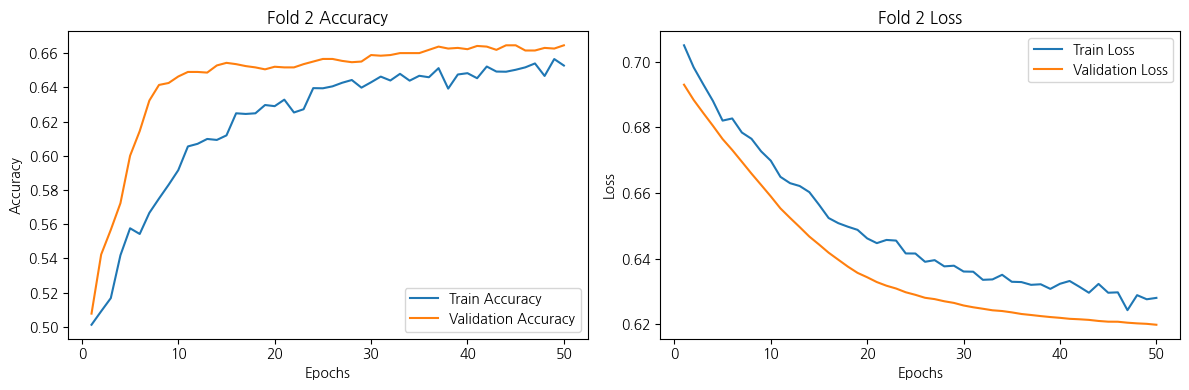

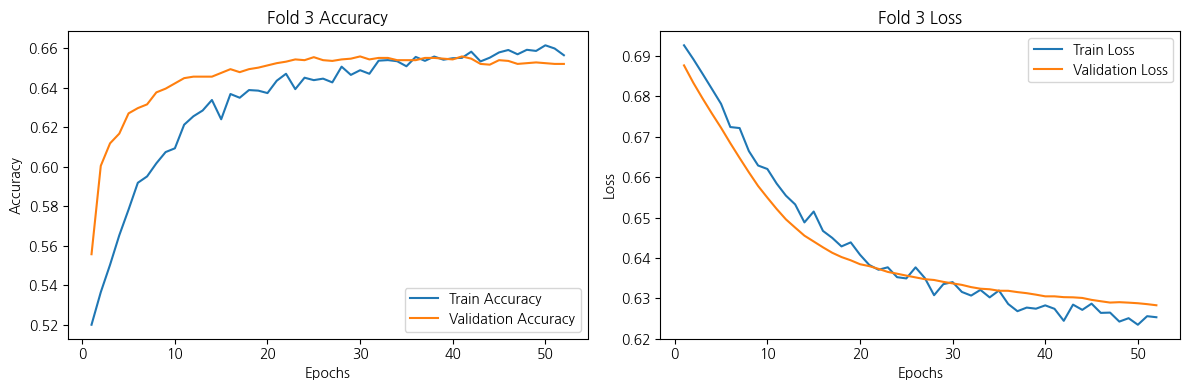

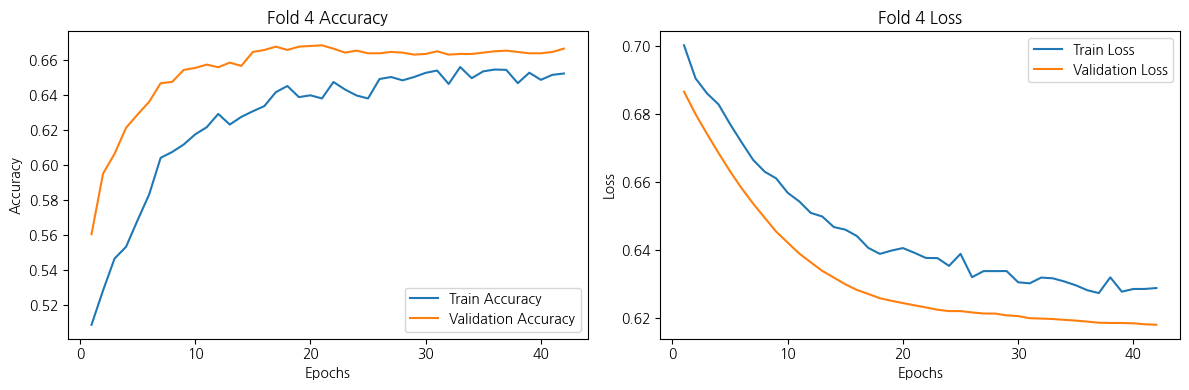

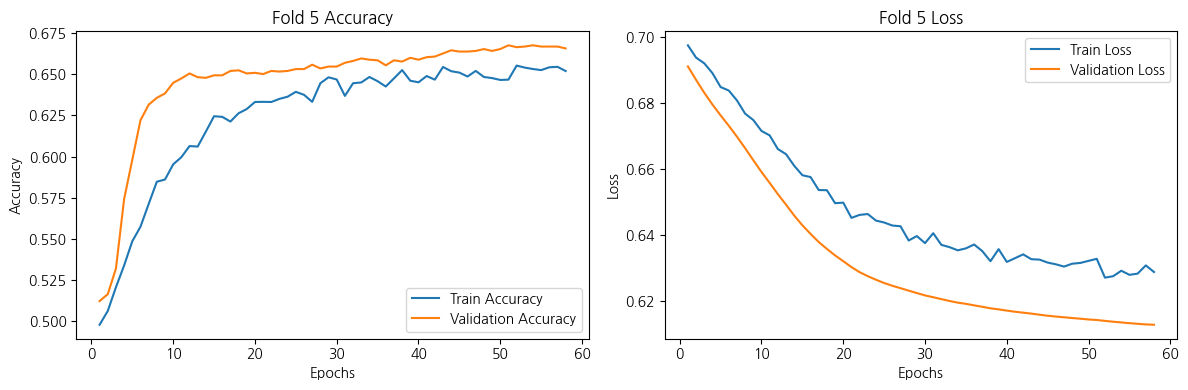

In [35]:
all_history = []
kf = KFold(n_splits= 5, shuffle= True, random_state= 42)
fold = 1
roc_auc_scores = []

for train_index, valid_index in kf.split(X_resampled):
    X_train_fold, X_valid_fold = X_resampled[train_index], X_resampled[valid_index]
    y_train_fold, y_valid_fold = y_resampled[train_index], y_resampled[valid_index]
    print(f"Fold {fold} 시작!")

    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation= "relu", input_shape = (X_train_fold.shape[1],)),
        tf.keras.layers.Dropout(0.30),
        tf.keras.layers.Dense(64, activation = "relu"),
        tf.keras.layers.Dropout(0.30),
        tf.keras.layers.Dense(32, activation = "relu"),
        tf.keras.layers.Dense(1, activation = "sigmoid")
    ])

    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate= 1e-5),
        loss = "binary_crossentropy",
        metrics = ["accuracy"]
    )

    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor = "val_loss",
        patience = 5,
        min_delta = 0.001,
        restore_best_weights = True
    )

    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data = (X_valid_fold, y_valid_fold),
        epochs = 100,
        callbacks = early_stop,
        verbose = 1,
    )

    all_history.append(history.history)
    y_valid_pred = model.predict(X_valid_fold).ravel()
    roc_auc = roc_auc_score(y_valid_fold, y_valid_pred)
    print(f"FOLD {fold} ROC-AUC SCORE {roc_auc:.4f}")
    roc_auc_scores.append(roc_auc)
    fold += 1

print(f"교차 검증 ROC-AUC 평균 점수 {np.mean(roc_auc_scores):.4f}")

for i, history in enumerate(all_history):
    epochs = range(1, len(history["loss"]) + 1)
    plt.figure(figsize = (12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, history["accuracy"], label = "Train Accuracy")
    plt.plot(epochs, history["val_accuracy"], label = "Validation Accuracy")
    plt.title(f"Fold {i+1} Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, history["loss"], label = "Train Loss")
    plt.plot(epochs, history["val_loss"], label = "Validation Loss")
    plt.title(f"Fold {i+1} Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [36]:
pred = model.predict(test_scaled).ravel()

sub_path = os.path.join(file_path, "데이터셋", "sample_submission.csv")
submission1 = pd.read_csv(sub_path)

submission1["채무 불이행 확률"] = pred * 100
submission1.to_csv("C:/Users/yunju/OneDrive/바탕 화면/submissions/채무불이행 예측/submission(2025-03-18).csv", index = False) 

submission1.head()

65/65 [==============================] - 0s 1ms/step


,UID,채무 불이행 확률
0,TEST_0000,55.407612
1,TEST_0001,49.354431
2,TEST_0002,41.225983
3,TEST_0003,31.948677
4,TEST_0004,48.803303
